## TODO

In [1]:
import torch
import torch.nn as nn
import os, sys
import numpy as np
import torch.nn.functional as F

# Add project root (one level up) to Python path 
project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
if project_root not in sys.path:
    sys.path.insert(0, project_root)

from models.parity_rnn import ParityRNN
from torch.nn.utils.rnn import pack_sequence, pad_packed_sequence

torch.manual_seed(42)

In [2]:
# Hyperparameters
hidden_size = 100       # number of hidden ReLU units
input_size = 2          # one-hot binary input
output_size = 2         # one-hot parity output
learning_rate = 0.06    # SGD learning rate
batch_size = 128        # training batch size
num_epochs = 1000       # number of training epochs
clip_norm = None        # no gradient clipping

# Optimizer example
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = ParityRNN(input_size, hidden_size, output_size)
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.0, weight_decay=0.0)
criterion = nn.MSELoss()


In [3]:
# Load training data from .npz
train_data = np.load('../data/training/train_data.npz', allow_pickle=True)
train_seqs = train_data['X']
train_labels = train_data['Y']
train_losses = []

val_data = np.load('../data/validation/val_data_50.npz', allow_pickle=True)
val_seqs = val_data['X']
val_labels = val_data['Y']
val_losses = []

one-hot encodings

In [4]:
def one_hot_seq(seq):
    tens = []
    for bits in seq:
        L = len(bits)
        t = torch.zeros(L, input_size)
        for i, b in enumerate(bits):
            t[i, b] = 1.0
        tens.append(t)
    return tens

In [5]:
train_tensors = one_hot_seq(train_seqs)
train_labels_tensor = torch.LongTensor(train_labels)

val_tensors = one_hot_seq(val_seqs)
val_labels_tensor = torch.LongTensor(val_labels)

In [6]:
def train_parity_rnn(n):
  model.train()
  total_train_loss = 0.0

  perm = torch.randperm(n)
  for i in range(0, n, batch_size):
      idx = perm[i : i+batch_size]
      batch_xs = [train_tensors[j].to(device) for j in idx.tolist()]
      batch_labels = train_labels_tensor[idx].to(device)

      packed_x = pack_sequence(batch_xs, enforce_sorted=False).to(device)

      logits, _ = model(packed_x)
        
      target = torch.zeros_like(logits)
      target[torch.arange(logits.size(0)), batch_labels] = 1.0

      # MSE on final output only
      loss = criterion(logits, target)

      optimizer.zero_grad()
      loss.backward()

      clip_value = 0.5
      torch.nn.utils.clip_grad_value_(model.parameters(), clip_value)

      # Update weights
      optimizer.step()

      # loss.item() is already averaged over batch_size
      total_train_loss += loss.item() * batch_labels.size(0)

  return total_train_loss

In [7]:
def validate_model(n):
    model.eval()
    total_val_loss = 0.0
    correct = 0
    
    with torch.no_grad():        
        for i in range(0, len(val_seqs), batch_size):
            end_idx = min(i + batch_size, len(val_seqs))
            batch_xs = [val_tensors[j].to(device) for j in range(i, end_idx)]
            batch_labels = val_labels_tensor[i:end_idx].to(device)
            
            packed_x = pack_sequence(batch_xs, enforce_sorted=False).to(device)
            logits, _ = model(packed_x)
            
            target = torch.zeros_like(logits)
            target[torch.arange(logits.size(0)), batch_labels] = 1.0
            
            loss = criterion(logits, target)
            total_val_loss += loss.item() * batch_labels.size(0)
            
            # Calculate accuracy
            predictions = torch.argmax(logits, dim=1)
            correct += (predictions == batch_labels).sum().item()
    
    return total_val_loss, correct

In [8]:
n = len(train_seqs)
m = len(val_seqs)

for epoch in range(1,1001):
    total_train_loss = train_parity_rnn(n)
    total_val_loss, correct = validate_model(m)
    avg_train_loss = total_train_loss / n
    train_losses.append((avg_train_loss, epoch))
    avg_val_loss = total_val_loss / m
    val_losses.append((avg_val_loss, epoch))
    val_accuracy = correct / m
    if epoch % 10 == 0:
        print(f"Epoch {epoch:4d} | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f} | Val Acc: {val_accuracy:.3f}")

Epoch   10 | Train Loss: 0.2509 | Val Loss: 0.2503 | Val Acc: 0.490
Epoch   20 | Train Loss: 0.2511 | Val Loss: 0.2503 | Val Acc: 0.500
Epoch   30 | Train Loss: 0.2508 | Val Loss: 0.2501 | Val Acc: 0.500
Epoch   40 | Train Loss: 0.2505 | Val Loss: 0.2503 | Val Acc: 0.480
Epoch   50 | Train Loss: 0.2505 | Val Loss: 0.2501 | Val Acc: 0.510
Epoch   60 | Train Loss: 0.2504 | Val Loss: 0.2500 | Val Acc: 0.500
Epoch   70 | Train Loss: 0.2504 | Val Loss: 0.2502 | Val Acc: 0.500
Epoch   80 | Train Loss: 0.2506 | Val Loss: 0.2501 | Val Acc: 0.490
Epoch   90 | Train Loss: 0.2504 | Val Loss: 0.2502 | Val Acc: 0.500
Epoch  100 | Train Loss: 0.2504 | Val Loss: 0.2507 | Val Acc: 0.490
Epoch  110 | Train Loss: 0.2506 | Val Loss: 0.2502 | Val Acc: 0.490
Epoch  120 | Train Loss: 0.2505 | Val Loss: 0.2500 | Val Acc: 0.510
Epoch  130 | Train Loss: 0.2503 | Val Loss: 0.2503 | Val Acc: 0.470
Epoch  140 | Train Loss: 0.2502 | Val Loss: 0.2504 | Val Acc: 0.490
Epoch  150 | Train Loss: 0.2504 | Val Loss: 0.25

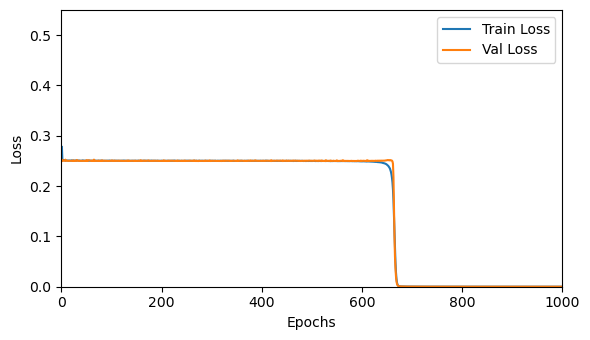

In [9]:
import matplotlib.pyplot as plt

train_losses_array = np.array(train_losses)
val_losses_array = np.array(val_losses)

# Extract epochs and losses
train_epochs = train_losses_array[:, 1]
train_values = train_losses_array[:, 0]

val_epochs = val_losses_array[:, 1]
val_values = val_losses_array[:, 0]

# Create the plot
plt.figure(figsize=(6, 3.5))
plt.plot(train_epochs, train_values, label="Train Loss")
plt.plot(val_epochs, val_values, label="Val Loss")

# Axis labels and limits to mimic style
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.xlim(0, 1000)
plt.ylim(0, 0.55)

# Optional grid and legend
plt.legend()
plt.tight_layout()
plt.show()

In [11]:
checkpoint = {
    "epoch": epoch,
    "model_state": model.state_dict(),
    "optimizer_state": optimizer.state_dict(),
    "train_losses": train_losses,
    "val_losses": val_losses,
}
torch.save(checkpoint, "../models/checkpoints/parity_rnn_checkpoint.pt")
